In [1]:
import csv

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
# from sklearn.grid_search import GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectFromModel

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

import warnings
warnings.filterwarnings('ignore')

//anaconda/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load Raw Training Data & Extract Features into Additional Columns

In [2]:
# Load training data
raw_train_data = pd.read_csv('../data/train.csv', parse_dates = ['Dates'], date_parser = pd.datetools.to_datetime)
raw_train_data['CategoryNum'] = raw_train_data['Category'].astype("category").cat.codes
raw_train_data['DistrictNum'] = raw_train_data['PdDistrict'].astype('category').cat.codes
raw_train_data['Year'] = raw_train_data['Dates'].apply(lambda s: s.year)
raw_train_data['Month'] = raw_train_data['Dates'].apply(lambda s: s.month)
raw_train_data['Day'] = raw_train_data['Dates'].apply(lambda s: s.day)
raw_train_data['DayNum'] = raw_train_data['Dates'].apply(lambda s: s.isoweekday())
raw_train_data['MinutesAfterMidnight'] = raw_train_data['Dates'].apply(lambda s: s.hour * 60 + s.minute)
raw_train_data.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,CategoryNum,DistrictNum,Year,Month,Day,DayNum,MinutesAfterMidnight
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,37,4,2015,5,13,3,1433
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,21,4,2015,5,13,3,1433
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,21,4,2015,5,13,3,1413
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,16,4,2015,5,13,3,1410
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,16,5,2015,5,13,3,1410


# Load Test Data & Extract Features into Additional Columns

In [3]:
# Load test data
test_data = pd.read_csv('../data/test.csv', parse_dates = ['Dates'], date_parser = pd.datetools.to_datetime)
test_data['DistrictNum'] = test_data['PdDistrict'].astype('category').cat.codes
test_data['Year'] = test_data['Dates'].apply(lambda s: s.year)
test_data['Month'] = test_data['Dates'].apply(lambda s: s.month)
test_data['Day'] = test_data['Dates'].apply(lambda s: s.day)
test_data['DayNum'] = test_data['Dates'].apply(lambda s: s.isoweekday())
test_data['MinutesAfterMidnight'] = test_data['Dates'].apply(lambda s: s.hour * 60 + s.minute)
test_data.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y,DistrictNum,Year,Month,Day,DayNum,MinutesAfterMidnight
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051,0,2015,5,10,7,1439
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432,0,2015,5,10,7,1431
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212,4,2015,5,10,7,1430
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,2,2015,5,10,7,1425
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,2,2015,5,10,7,1425


# Select Features to Form Training Data Set

In [4]:
train_data = raw_train_data.loc[:,['Year','Month','Day','MinutesAfterMidnight','DayNum','DistrictNum','X','Y']]
train_data.head()

,Year,Month,Day,MinutesAfterMidnight,DayNum,DistrictNum,X,Y
0,2015,5,13,1433,3,4,-122.425892,37.774599
1,2015,5,13,1433,3,4,-122.425892,37.774599
2,2015,5,13,1413,3,4,-122.424363,37.800414
3,2015,5,13,1410,3,4,-122.426995,37.800873
4,2015,5,13,1410,3,5,-122.438738,37.771541


In [5]:
train_data.describe()

,Year,Month,Day,MinutesAfterMidnight,DayNum,DistrictNum,X,Y
count,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000
mean,2008.712046,6.436509,15.570623,824.914304,3.992691,4.445310,-122.422616,37.771020
std,3.631194,3.428972,8.783005,393.603855,1.972023,2.863715,0.030354,0.456893
min,2003.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-122.513642,37.707879
25%,2006.000000,3.000000,8.000000,570.000000,2.000000,2.000000,-122.432952,37.752427
50%,2009.000000,6.000000,16.000000,885.000000,4.000000,4.000000,-122.416420,37.775421
75%,2012.000000,9.000000,23.000000,1140.000000,6.000000,7.000000,-122.406959,37.784369
max,2015.000000,12.000000,31.000000,1439.000000,7.000000,9.000000,-120.500000,90.000000


In [6]:
train_labels = pd.Series(raw_train_data.loc[:,'Category'].astype("category"))
train_labels.head()

0          WARRANTS
1    OTHER OFFENSES
2    OTHER OFFENSES
3     LARCENY/THEFT
4     LARCENY/THEFT
Name: Category, dtype: category
Categories (39, object): [ARSON, ASSAULT, BAD CHECKS, BRIBERY, ..., VANDALISM, VEHICLE THEFT, WARRANTS, WEAPON LAWS]

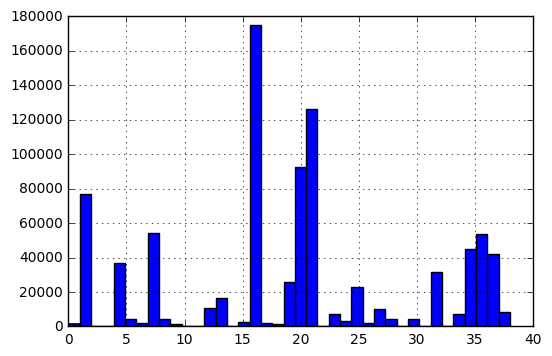

In [7]:
label_data = pd.DataFrame({'Category': raw_train_data.loc[:,'Category'].astype('category')})
fp_cat = plt.figure(figsize=(6, 4))
a_cat = fp_cat.add_subplot(111)
train_labels.cat.codes.hist(bins=39, ax=a_cat)
plt.show()

# Attempt to See If Assumption Works

### My assumption is that the district and the day of the week are the most influencial factors.  The plot proved me wrong. 

In [8]:
# # Determine the total occurrences of each category given a DoW/district combination
plot_data = pd.DataFrame({'DistrictNum': raw_train_data.loc[:,'DistrictNum'],
                          'CategoryNum': raw_train_data.loc[:,'CategoryNum'],
                          'DayNum': raw_train_data.loc[:,'DayNum']})
plot_data['Quantity'] = [1] * len(plot_data.loc[:,'DistrictNum'])
agg_plot_data = plot_data.groupby(['DayNum', 'DistrictNum', 'CategoryNum'])
plot_data['Counts'] = agg_plot_data.transform(sum)
plot_data['DayDistrict'] = plot_data.apply(lambda r: r['DayNum'] * 10 + r['DistrictNum'], axis=1)
plot_data.head()

,CategoryNum,DayNum,DistrictNum,Quantity,Counts,DayDistrict
0,37,3,4,1,733,34
1,21,3,4,1,1995,34
2,21,3,4,1,1995,34
3,16,3,4,1,3956,34
4,16,3,5,1,1285,35


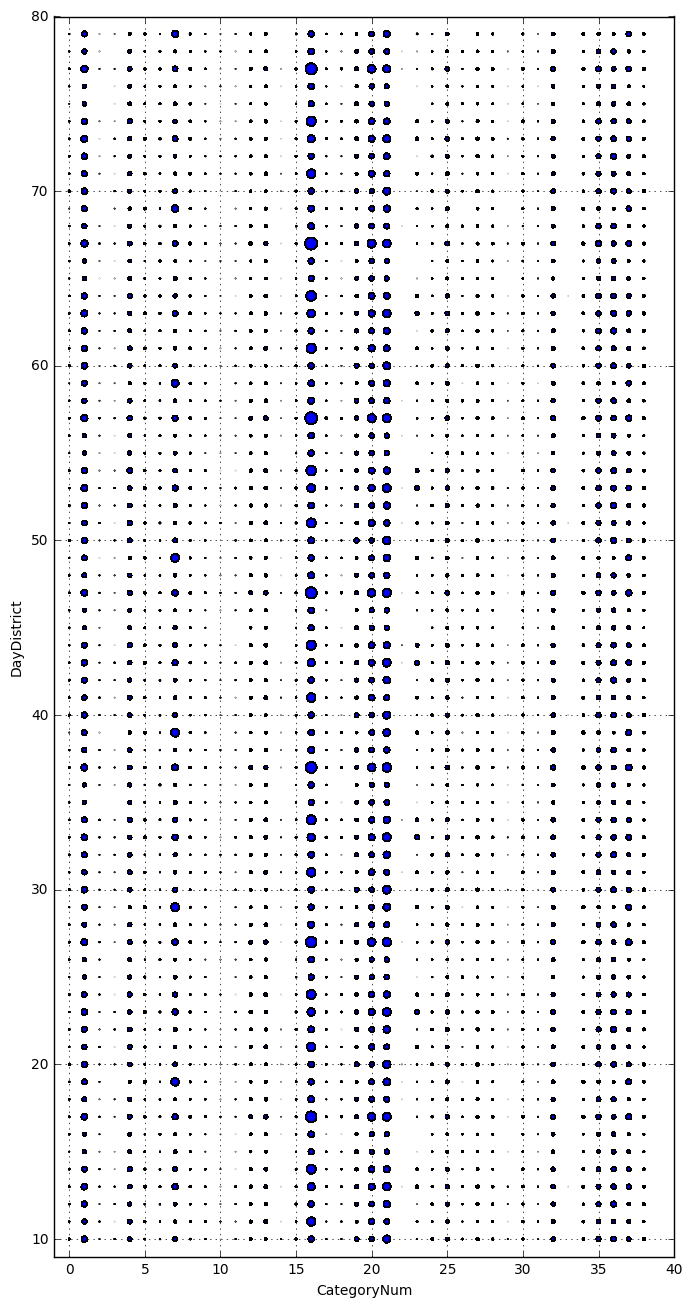

In [9]:
# The size of a circle represents the occurrence count.
# x-axis covers the 39 categories.
# y-axis is the combination of "day of the week" and "district" represented in 2 digits.
# The scattered plot shows that there is no correlation between category and day of the week.
# The scattered plot shows that there is some correlation between category and district.
fp_dist = plt.figure(figsize=(8, 16))
a_dist = fp_dist.add_subplot(111, xlim=(-1, 40), ylim=(9, 80))
plot_data.plot(kind='scatter', y='DayDistrict', x='CategoryNum', s=plot_data['Counts']/100.0, grid=True, ax=a_dist)
plt.show()

# Attempt to Use PCA to Determine Important Features

In [10]:
# Copied from Dan's in-class notebook.
# a handy function for vizualizing principle components as a heatmap
# this allows you to see what dimensions in the 'original space' are
# active

def visualize_pca_comps_heatmap(plot, comps):
    heatmap = plot.pcolor(abs(comps), cmap=plt.cm.Blues)
    
    x_lab = [i for i in range(comps.shape[1])]
    y_lab = [i for i in (range(comps.shape[0]))]
    
    plot.set_xticks(np.arange(comps.shape[1])+0.5, minor=False)
    plot.set_yticks(np.arange(comps.shape[0])+0.5, minor=False)
    
    # want a more natural, table-like display
    plot.invert_yaxis()
    
    plot.set_xticklabels(x_lab, minor=False)
    plot.set_yticklabels(y_lab, minor=False)
    
    plt.title('Heatmap of PCA components Rows: components, Cols: Original dimensions')

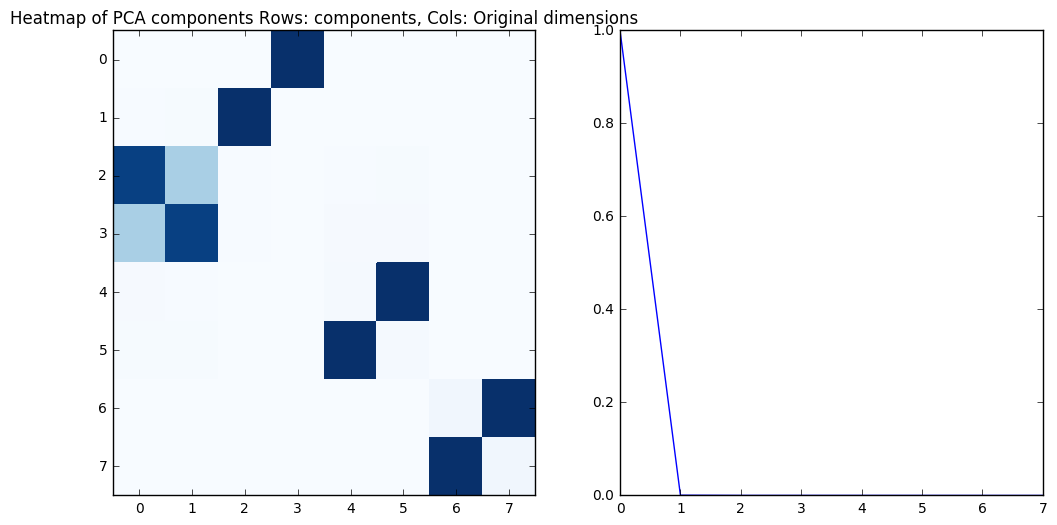

In [11]:
n_comp = 8
plt.figure(figsize=(12, 6))

pca_train = PCA(n_components = n_comp)
pca_train.fit(train_data.as_matrix(columns=('Year','Month','Day','MinutesAfterMidnight','DayNum','DistrictNum','X','Y')), train_labels)
p1 = plt.subplot(1, 2, 1)
visualize_pca_comps_heatmap(p1, pca_train.components_)

plt.subplot(1, 2, 2)
plt.plot(pca_train.explained_variance_ratio_)
plt.show()

The result is not informative at all.

# Attempt to Use Boosted Tree to Determine Important Features

In [12]:
X_train = train_data.as_matrix(columns=('Year','Month','Day','MinutesAfterMidnight','DayNum','DistrictNum','X','Y'))
y_train = train_labels.values

In [13]:
X_train.shape

(878049, 8)

In [14]:
y_train.shape

(878049,)

## Use default values to get a baseline

In [15]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
print(xgb_model.feature_importances_)

[ 0.09585173  0.01236925  0.03527821  0.26011217  0.02784075  0.0465736
  0.23859523  0.28337908]


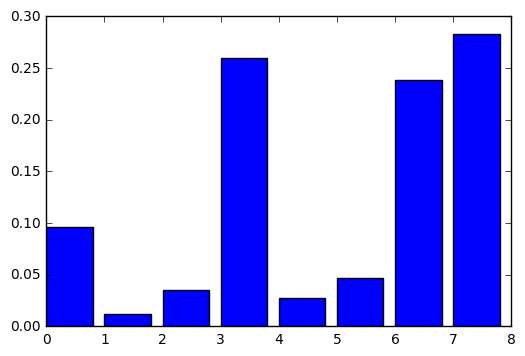

In [16]:
plt.figure(figsize=(6, 4))
plt.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
plt.show()

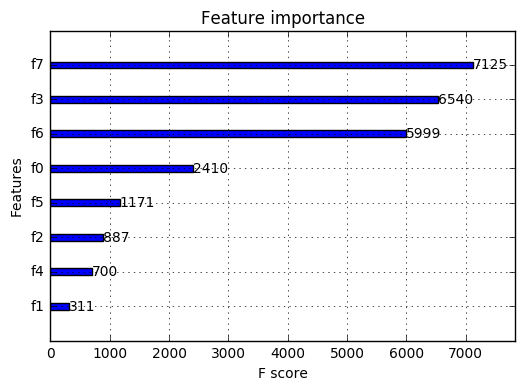

In [17]:
fp = plt.figure(figsize=(6, 4))
a = fp.add_subplot(111)
plot_importance(xgb_model, ax=a)
plt.show()

The most important features seem to be Y (latitude), MinutesAfterMidnight, and X (longitude).

## Split up the training data set for cross validation

In [18]:
X_train_pd, X_dev_pd, y_train_pd, y_dev_pd = train_test_split(train_data.loc[:,['Year','Month','Day','MinutesAfterMidnight','DayNum','DistrictNum','X','Y']], train_labels, test_size = 0.2, random_state = 42)
X_train = X_train_pd.as_matrix(columns=('Year','Month','Day','MinutesAfterMidnight','DayNum','DistrictNum','X','Y'))
y_train = y_train_pd.codes
X_dev = X_dev_pd.as_matrix(columns=('Year','Month','Day','MinutesAfterMidnight','DayNum','DistrictNum','X','Y'))
y_dev = y_dev_pd.codes
(X_train.shape, X_dev.shape)

((702439, 8), (175610, 8))

## Vary the parameters a little

In [19]:
xgb_model_2 = XGBClassifier(objective='multi:softmax', max_depth=5)
xgb_model_2.fit(X_train, y_train, eval_metric='mlogloss')
print(xgb_model_2.feature_importances_)

[ 0.08530888  0.03941248  0.063119    0.22413811  0.04183504  0.03291837
  0.24630763  0.2669605 ]


In [20]:
y_dev_pred_2 = xgb_model_2.predict(X_dev)

In [21]:
y_dev_pred_2

array([16, 21, 16, ..., 16, 16,  7], dtype=int8)

In [22]:
accuracy = accuracy_score(y_dev, y_dev_pred_2)
print("Accuracy = {:f}\n".format(accuracy))

Accuracy = 0.281197



In [23]:
results = []
thresholds = np.sort(xgb_model_2.feature_importances_)
for t in thresholds:
    selection = SelectFromModel(xgb_model_2, threshold=t, prefit=True)
    select_X_train = selection.transform(X_train)
    selection_model = XGBClassifier(objective='multi:softmax', max_depth=5)
    selection_model.fit(select_X_train, y_train, eval_metric='mlogloss')
    select_X_dev = selection.transform(X_dev)
    select_y_dev_pred = selection_model.predict(select_X_dev)
    accuracy = accuracy_score(y_dev, select_y_dev_pred)
    results.append((t, accuracy, select_X_train[1]))

In [26]:
for r in results:
    print("Threshold = {:f}".format(r[0]))
    print("    Accuracy = {:f}".format(r[1]))
    print("    n = {}\n".format(r[2]))

Threshold = 0.032918
    Accuracy = 0.281197
    n = [  2.01200000e+03   2.00000000e+00   2.60000000e+01   6.08000000e+02
   7.00000000e+00   3.00000000e+00  -1.22408831e+02   3.77503895e+01]

Threshold = 0.039412
    Accuracy = 0.280468
    n = [  2.01200000e+03   2.00000000e+00   2.60000000e+01   6.08000000e+02
   7.00000000e+00  -1.22408831e+02   3.77503895e+01]

Threshold = 0.041835
    Accuracy = 0.281578
    n = [ 2012.            26.           608.             7.          -122.40883112
    37.75038952]

Threshold = 0.063119
    Accuracy = 0.280781
    n = [ 2012.            26.           608.          -122.40883112    37.75038952]

Threshold = 0.085309
    Accuracy = 0.281117
    n = [ 2012.           608.          -122.40883112    37.75038952]

Threshold = 0.224138
    Accuracy = 0.277564
    n = [ 608.         -122.40883112   37.75038952]

Threshold = 0.246308
    Accuracy = 0.262918
    n = [-122.40883112   37.75038952]

Threshold = 0.266961
    Accuracy = 0.237834
    n = [ 

In [27]:
xgb_model_3 = XGBClassifier(objective='multi:softprob', max_depth=6)
xgb_model_3.fit(X_train, y_train, eval_metric='mlogloss')
print(xgb_model_3.feature_importances_)

[ 0.08629371  0.05165939  0.07784794  0.20998137  0.04747545  0.02863104
  0.24182269  0.25628844]


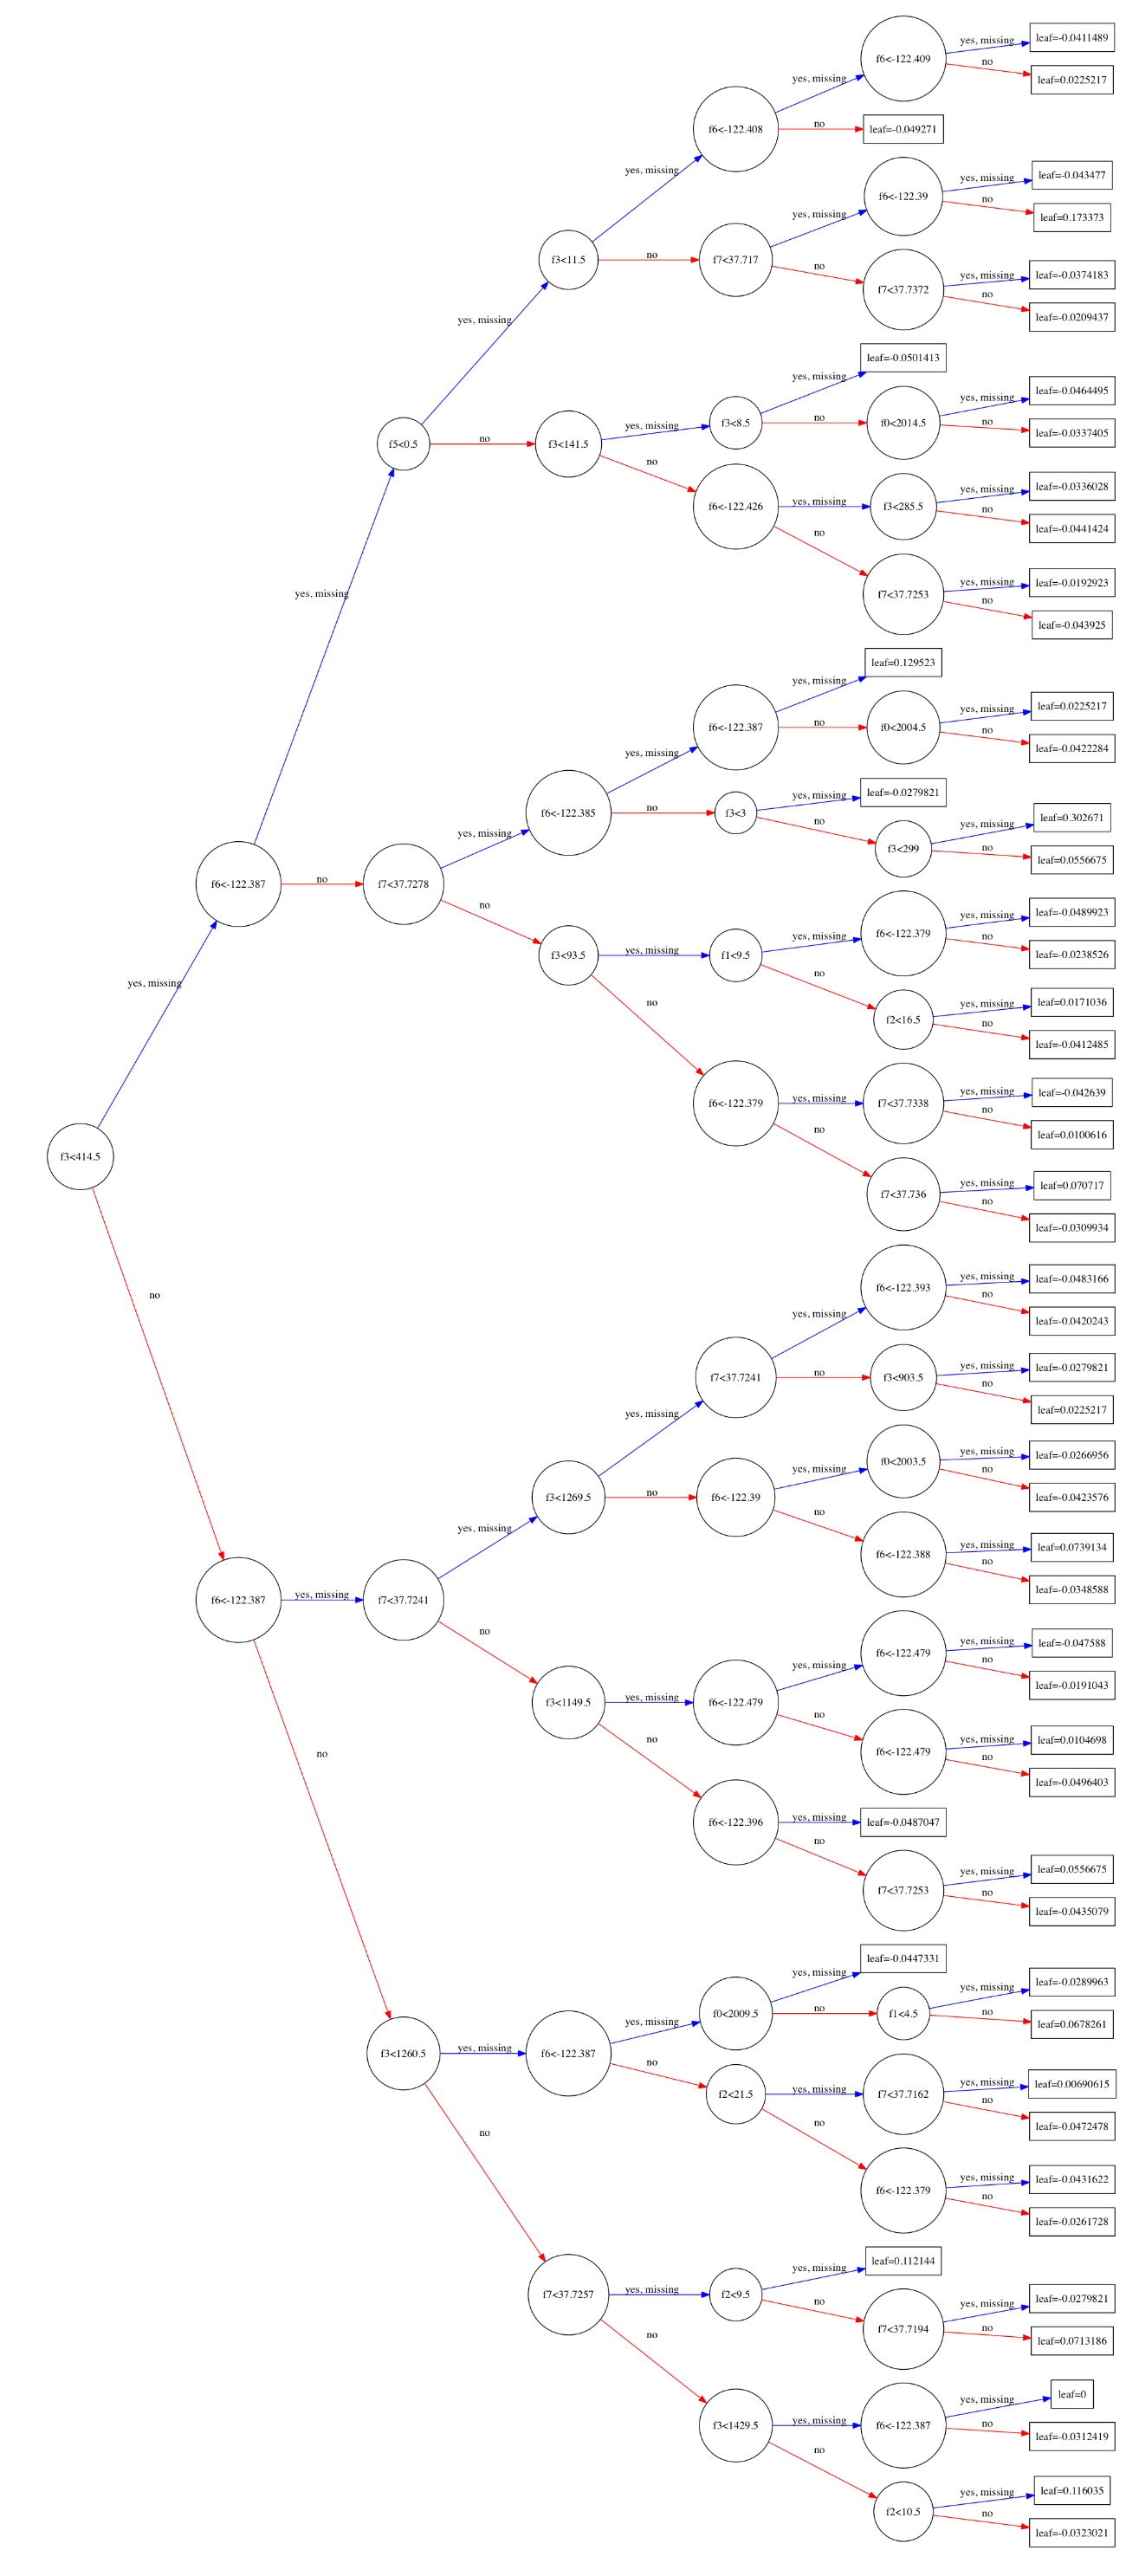

In [28]:
fp3 = plt.figure(figsize=(16, 40))
a3 = fp3.add_subplot(111)
plot_tree(xgb_model_3, ax=a3, rankdir='LR')
plt.show()

In [29]:
y_dev_pred_3 = xgb_model_3.predict(X_dev)

In [30]:
xgb_model_3_accuracy = accuracy_score(y_dev, y_dev_pred_3)
print("Accuracy = {:f}".format(xgb_model_3_accuracy))

Accuracy = 0.288178


In [31]:
y_dev_pred_3

array([16, 21, 21, ..., 16, 16, 21], dtype=int8)

# Generate a CSV File for Kaggle Submission

In [32]:
test_data.shape

(884262, 13)

In [33]:
X_test = test_data.as_matrix(columns=('Year','Month','Day','MinutesAfterMidnight','DayNum','DistrictNum','X','Y'))

In [34]:
X_test.shape

(884262, 8)

In [35]:
y_test_pred_prob = xgb_model_3.predict_proba(X_test)

In [36]:
y_test_pred_prob

array([[  2.66435975e-03,   9.51001793e-02,   1.81229669e-04, ...,
          1.93100125e-01,   2.60227509e-02,   2.05849987e-02],
       [  3.91212432e-03,   1.08644791e-01,   1.62555603e-04, ...,
          3.81898098e-02,   6.06791452e-02,   2.98513789e-02],
       [  2.47636810e-03,   6.88437894e-02,   1.99312519e-04, ...,
          6.49105757e-02,   2.88794562e-02,   5.47617767e-03],
       ..., 
       [  7.44506251e-04,   1.16079405e-01,   7.24129565e-03, ...,
          9.08545405e-02,   3.20500545e-02,   4.35239682e-03],
       [  6.17309706e-04,   6.88002706e-02,   1.60059370e-02, ...,
          1.13215983e-01,   7.86181912e-03,   8.04530736e-03],
       [  5.70253353e-04,   6.67418018e-02,   6.63778558e-03, ...,
          7.08587393e-02,   9.47016012e-03,   2.40790262e-03]], dtype=float32)

In [37]:
column_names = train_labels.cat.categories.tolist()
results = pd.DataFrame(y_test_pred_prob, columns=column_names)
results.head()

,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0.002664,0.095100,0.000181,0.001048,0.019873,0.001817,0.008978,0.020991,0.002610,0.003971,...,0.000267,0.008709,0.001838,0.035247,0.000153,0.004874,0.041338,0.193100,0.026023,0.020585
1,0.003912,0.108645,0.000163,0.001696,0.013275,0.001712,0.008304,0.041661,0.003192,0.000317,...,0.000231,0.010694,0.000913,0.067401,0.000137,0.004211,0.036438,0.038190,0.060679,0.029851
2,0.002476,0.068844,0.000199,0.000889,0.060281,0.001524,0.008734,0.022292,0.006987,0.000415,...,0.000260,0.012351,0.000389,0.036597,0.000159,0.006875,0.057855,0.064911,0.028879,0.005476
3,0.002974,0.122667,0.000211,0.002408,0.013734,0.002446,0.008628,0.018316,0.004445,0.000422,...,0.000476,0.006540,0.000423,0.044471,0.000163,0.003489,0.066037,0.096600,0.022360,0.023513
4,0.002974,0.122667,0.000211,0.002408,0.013734,0.002446,0.008628,0.018316,0.004445,0.000422,...,0.000476,0.006540,0.000423,0.044471,0.000163,0.003489,0.066037,0.096600,0.022360,0.023513


In [38]:
results.to_csv('../data/yhfan_submission.csv', index_label='Id')

# Attempt to Use Kernel PCA to Determine Important Features (unsuccessfully)

### Running KernelPCA required too much memory.  Running against the full set killed the python kernel.  Running against just the 2003 subset still required a lot of memory and took too long.  It was a failed experiment.

In [ ]:
# train_data[train_data['Year'] == 2003].shape

In [ ]:
# train_labels[train_data['Year'] == 2003].shape

In [ ]:
# n_comp = 7
# train_data_2003 = train_data[train_data['Year'] == 2003].as_matrix(columns=('Month','Day','MinutesAfterMidnight','DayNum','DistrictNum','X','Y'))
# train_labels_2003 = train_labels[train_data['Year'] == 2003].values
# kpca_train = KernelPCA(n_components = n_comp, kernel='poly')
# kpca_train.fit(train_data_2003, train_labels_2003)

# plt.figure(figsize=(12, 6))

# p2 = plt.subplot(1, 2, 1)
# visualize_pca_comps_heatmap(p2, kpca_train.alphas_)

# plt.subplot(1, 2, 2)
# plt.plot(kpca_train.explained_variance_ratio_)